<a href="https://colab.research.google.com/github/Udaykamal2005/OIBSIP/blob/main/Project_4_Proposal_Level_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Cell 1: install dependencies (run this first)
!pip install -q nltk scikit-learn matplotlib seaborn wordcloud

# Download NLTK resources (for tokenization and stopwords)
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
# Cell 2: Upload your CSV file (use your pattern)
from google.colab import files
import io, os
import pandas as pd

print("Please upload the dataset CSV (example: 'Twitter_Data.csv').")
uploaded = files.upload()

uploaded_files = list(uploaded.keys())
print("Uploaded:", uploaded_files)

# Try to auto-load a common name if present, otherwise load the first uploaded file
if 'Twitter_Data.csv' in uploaded_files:
    filename = 'Twitter_Data.csv'
else:
    filename = uploaded_files[0]

# read into df (safe reading)
try:
    df = pd.read_csv(io.BytesIO(uploaded[filename]), low_memory=False)
    print(f"Loaded {filename} -> shape {df.shape}")
except Exception as e:
    # fallback: try pandas read_table or latin1
    try:
        df = pd.read_csv(io.BytesIO(uploaded[filename]), encoding='latin1', low_memory=False)
        print(f"Loaded with latin1 encoding: {filename} -> shape {df.shape}")
    except Exception as e2:
        raise RuntimeError(f"Failed to read {filename}: {e} ; {e2}")

# quick peek
pd.set_option('display.max_columns', None)
print("\nColumns:", df.columns.tolist())
display(df.head())


Please upload the dataset CSV (example: 'Twitter_Data.csv').


Saving Twitter_Data.csv to Twitter_Data.csv
Uploaded: ['Twitter_Data.csv']
Loaded Twitter_Data.csv -> shape (162980, 2)

Columns: ['clean_text', 'category']


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [ ]:
# Cell 3: show columns and try to auto-find text & label columns
print("All columns:", df.columns.tolist())

# Normalize column names to help matching
def norm(c):
    return str(c).strip().lower().replace(' ', '_').replace('-', '_')

col_map = {norm(c): c for c in df.columns}

# candidate text columns
text_candidates = [k for k in col_map if any(token in k for token in ['text','tweet','message','content','status'])]
label_candidates = [k for k in col_map if any(token in k for token in ['sentiment','label','polarity','target','class'])]

print("Text candidates (normalized -> original):")
for k in text_candidates:
    print(k, "->", col_map[k])

print("\nLabel candidates (normalized -> original):")
for k in label_candidates:
    print(k, "->", col_map[k])

# choose defaults
text_col = col_map[text_candidates[0]] if text_candidates else None
label_col = col_map[label_candidates[0]] if label_candidates else None
print("\nAuto-selected:", text_col, label_col)

# If none found, print first 5 columns as hint
if text_col is None or label_col is None:
    print("\nIf auto-detect failed, pick which columns contain the tweet text and the label (print columns above).")
else:
    display(df[[text_col, label_col]].head())


All columns: ['clean_text', 'category']
Text candidates (normalized -> original):
clean_text -> clean_text

Label candidates (normalized -> original):

Auto-selected: clean_text None

If auto-detect failed, pick which columns contain the tweet text and the label (print columns above).


In [ ]:
import numpy as np

# Explicitly setting column names based on the loaded dataset.
# The 'clean_text' column contains the text data.
text_col = 'clean_text'

# The 'category' column contains the label data.
label_col = 'category'

# Ensure columns exist
if text_col not in df.columns or label_col not in df.columns:
    raise RuntimeError(f"Columns not found: {text_col} or {label_col}. See df.columns for options.")

# Drop rows missing text or label
df = df[[text_col, label_col]].rename(columns={text_col: 'text', label_col: 'label'}).dropna().reset_index(drop=True)
print("After keeping text+label -> shape:", df.shape)

# Normalize labels to common form: numeric 0/1/2 or strings like 'positive','negative','neutral'
df['label_raw'] = df['label']
# try common conversions
def normalize_label(x):
    s = str(x).strip().lower()
    # examples: 0/1, 1/0, 2 for neutral, or 'positive','negative','neutral'
    if s in ['0','-1','negative','neg','0.0','0.00','2']:  # dataset specific may differ
        return 'negative'
    if s in ['1','positive','pos','1.0','1.00']:
        return 'positive'
    if s in ['2','neutral','neu','0.5']:
        return 'neutral'
    # fallback: try interpret as int 0/1
    try:
        v = int(float(s))
        return 'positive' if v==1 else 'negative' if v==0 else 'neutral'
    except:
        return s

df['label_clean'] = df['label_raw'].map(normalize_label)
# show unique labels
print("Unique raw labels (sample):", df['label_raw'].unique()[:20])
print("Unique cleaned labels:", df['label_clean'].unique())
display(df.head())

After keeping text+label -> shape: (162969, 2)
Unique raw labels (sample): [-1.  0.  1.]
Unique cleaned labels: ['neutral' 'negative' 'positive']


,text,label,label_raw,label_clean
0,when modi promised “minimum government maximum...,-1.0,-1.0,neutral
1,talk all the nonsense and continue all the dra...,0.0,0.0,negative
2,what did just say vote for modi welcome bjp t...,1.0,1.0,positive
3,asking his supporters prefix chowkidar their n...,1.0,1.0,positive
4,answer who among these the most powerful world...,1.0,1.0,positive


In [ ]:
# Cell 5: define a cleaning function (lowercase, remove URLs/mentions, punctuation, stopwords, lemmatize)
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(s):
    if not isinstance(s, str):
        return ""
    s = s.lower()
    s = re.sub(r'http\S+|www\S+', '', s)            # remove urls
    s = re.sub(r'@\w+', '', s)                      # remove mentions
    s = re.sub(r'#', '', s)                         # remove hashtag symbol only
    s = re.sub(r'[^a-z0-9\s]', ' ', s)              # keep alphanum
    tokens = s.split()
    tokens = [t for t in tokens if t not in stop_words and len(t)>1]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

# Apply cleaning (sample first to show speed)
df['text_clean'] = df['text'].astype(str).apply(clean_text)
display(df[['text','text_clean','label_clean']].head(8))


,text,text_clean,label_clean
0,when modi promised “minimum government maximum...,modi promised minimum government maximum gover...,neutral
1,talk all the nonsense and continue all the dra...,talk nonsense continue drama vote modi,negative
2,what did just say vote for modi welcome bjp t...,say vote modi welcome bjp told rahul main camp...,positive
3,asking his supporters prefix chowkidar their n...,asking supporter prefix chowkidar name modi gr...,positive
4,answer who among these the most powerful world...,answer among powerful world leader today trump...,positive
5,kiya tho refresh maarkefir comment karo,kiya tho refresh maarkefir comment karo,negative
6,surat women perform yagna seeks divine grace f...,surat woman perform yagna seek divine grace na...,negative
7,this comes from cabinet which has scholars lik...,come cabinet scholar like modi smriti hema tim...,negative


Label counts:
label_clean
positive    72249
negative    55211
neutral     35509
Name: count, dtype: int64


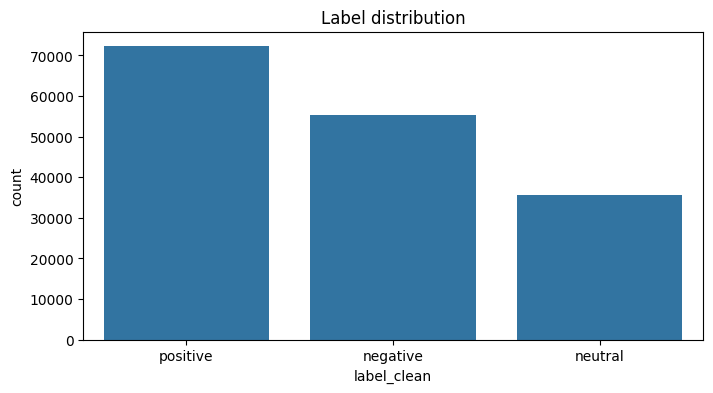

Top words: [('modi', 155554), ('india', 30992), ('bjp', 14647), ('people', 14416), ('like', 12936), ('congress', 12927), ('election', 11690), ('narendra', 11466), ('vote', 10926), ('govt', 10025), ('one', 9661), ('indian', 9378), ('say', 9254), ('year', 9180), ('time', 8890), ('country', 8696), ('dont', 8405), ('modis', 7790), ('nation', 7391), ('know', 7340)]


In [ ]:
# Cell 6: simple EDA
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
plt.rcParams['figure.figsize'] = (8,4)

# class counts
counts = df['label_clean'].value_counts()
print("Label counts:")
print(counts)

# barplot
sns.barplot(x=counts.index, y=counts.values)
plt.title("Label distribution")
plt.ylabel("count")
plt.show()

# most common words overall (top 20)
all_words = " ".join(df['text_clean']).split()
common = Counter(all_words).most_common(20)
print("Top words:", common)


In [ ]:
# Cell 7: train-test split and label encoding
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Keep only positive/negative/neutral (or whatever labels exist) — drop weird labels
df_model = df[df['label_clean'].isin(['positive','negative','neutral'])].copy()
print("Model dataset shape:", df_model.shape)

le = LabelEncoder()
df_model['label_num'] = le.fit_transform(df_model['label_clean'])  # mapping printed next
print("Label mapping:", dict(zip(le.classes_, le.transform(le.classes_))))

X = df_model['text_clean']
y = df_model['label_num']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
print("Train/Test sizes:", X_train.shape[0], X_test.shape[0])


Model dataset shape: (162969, 5)
Label mapping: {'negative': np.int64(0), 'neutral': np.int64(1), 'positive': np.int64(2)}
Train/Test sizes: 130375 32594


In [ ]:
# Cell 8: TF-IDF + Logistic Regression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

tfidf = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
clf = LogisticRegression(max_iter=1000, solver='liblinear', multi_class='auto')

pipeline = Pipeline([
    ('tfidf', tfidf),
    ('clf', clf)
])

print("Training model (this may take 10-60 seconds depending on dataset size)...")
pipeline.fit(X_train, y_train)
print("Training finished.")


Training model (this may take 10-60 seconds depending on dataset size)...


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Training finished.


Accuracy on test set: 0.8691

Classification report:
              precision    recall  f1-score   support

    negative       0.84      0.95      0.89     11042
     neutral       0.86      0.71      0.78      7102
    positive       0.90      0.88      0.89     14450

    accuracy                           0.87     32594
   macro avg       0.87      0.85      0.85     32594
weighted avg       0.87      0.87      0.87     32594



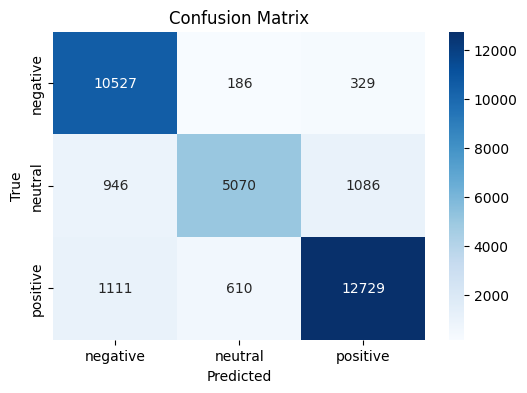

In [ ]:
# Cell 9: evaluation
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import numpy as np

y_pred = pipeline.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print(f"Accuracy on test set: {acc:.4f}\n")
print("Classification report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('True'); plt.title('Confusion Matrix')
plt.show()


In [ ]:
# Cell 10: try predictions on custom sentences
samples = [
    "I love this product, very good quality!",
    "This is the worst experience ever, I hate it.",
    "It's okay, not great but not bad either."
]
pred = pipeline.predict(samples)
for s,p in zip(samples,pred):
    print(f"Text: {s}\nPredicted: {le.inverse_transform([p])[0]}\n")



Text: I love this product, very good quality!
Predicted: positive

Text: This is the worst experience ever, I hate it.
Predicted: neutral

Text: It's okay, not great but not bad either.
Predicted: positive



DATASET-2

In [ ]:
# Cell 1 — Install libraries (XGBoost might be needed later)
!pip install -q xgboost

import os, re, warnings, string
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


In [ ]:
# Cell 2 — Load the CSV file
csv_path = '/mnt/data/user_reviews.csv'

if os.path.exists(csv_path):
    df = pd.read_csv(csv_path)
else:
    from google.colab import files
    uploaded = files.upload()
    file_name = list(uploaded.keys())[0]
    df = pd.read_csv(file_name)

print("Loaded shape:", df.shape)
print("Columns:", df.columns.tolist())
df.head()


Saving USvideos.csv to USvideos.csv
Loaded shape: (40949, 16)
Columns: ['video_id', 'trending_date', 'title', 'channel_title', 'category_id', 'publish_time', 'tags', 'views', 'likes', 'dislikes', 'comment_count', 'thumbnail_link', 'comments_disabled', 'ratings_disabled', 'video_error_or_removed', 'description']


,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,False,I know it's been a while since we did this sho...


In [ ]:
# Cell 3 — Identify text & label columns
if 'Translated_Review' in df.columns:
    text_col = 'Translated_Review'
else:
    text_col = df.columns[0]

if 'Sentiment' in df.columns:
    label_col = 'Sentiment'
else:
    label_col = df.columns[-1]

print("TEXT COLUMN =", text_col)
print("LABEL COLUMN =", label_col)

df = df[[text_col, label_col]].rename(columns={text_col:'review', label_col:'sentiment'})
df.dropna(subset=['review'], inplace=True)
df.head()


TEXT COLUMN = video_id
LABEL COLUMN = description


,review,sentiment
0,2kyS6SvSYSE,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,"One year after the presidential election, John..."
2,5qpjK5DgCt4,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,I know it's been a while since we did this sho...


In [ ]:
# Cell 4 — Fast text cleaning
STOPWORDS = {
"i","me","my","myself","we","our","ours","ourselves","you","your","yours","yourself","yourselves",
"he","him","his","himself","she","her","hers","herself","it","its","itself","they","them","their",
"theirs","themselves","what","which","who","whom","this","that","these","those","am","is","are",
"was","were","be","been","being","have","has","had","having","do","does","did","doing","a","an",
"the","and","but","if","or","because","as","until","while","of","at","by","for","with","about",
"against","between","into","through","during","before","after","above","below","to","from","up",
"down","in","out","on","off","over","under","again","further","then","once","here","there","when",
"where","why","how","all","any","both","each","few","more","most","other","some","such","no","nor",
"not","only","own","same","so","than","too","very","s","t","can","will","just","don","should","now"
}

def clean_text(t):
    t = str(t).lower()
    t = re.sub(r"http\S+|www\S+", "", t)
    t = re.sub(r"[^a-z\s]", " ", t)
    tokens = t.split()
    tokens = [w for w in tokens if w not in STOPWORDS and len(w) > 1]
    return " ".join(tokens)

df["clean_review"] = df["review"].map(clean_text)
df.head()


,review,sentiment,clean_review
0,2kyS6SvSYSE,SHANTELL'S CHANNEL - https://www.youtube.com/s...,kys svsyse
1,1ZAPwfrtAFY,"One year after the presidential election, John...",zapwfrtafy
2,5qpjK5DgCt4,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...,qpjk dgct
3,puqaWrEC7tY,Today we find out if Link is a Nickelback amat...,puqawrec ty
4,d380meD0W0M,I know it's been a while since we did this sho...,med


In [ ]:
# Cell 5 — Filter to Positive / Negative / Neutral
df = df[df['sentiment'].isin(['Positive', 'Negative', 'Neutral'])].reset_index(drop=True)
df['sentiment'].value_counts()


,count
sentiment,


In [ ]:
# Cell 6 — Sample dataset for fast training
sample_size = 6000  # You can increase this to 10k or more if RAM allows

if len(df) > sample_size:
    df_sample = df.groupby('sentiment', group_keys=False).apply(
        lambda x: x.sample(frac=sample_size/len(df), random_state=42)
    )
else:
    df_sample = df.copy()

print("Final training sample:", df_sample.shape)
df_sample.head()


Final training sample: (0, 3)


,review,sentiment,clean_review


In [ ]:
# Cell 8 — Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

X_train.shape, X_test.shape


((4800, 2000), (1200, 2000))

In [ ]:
# Cell 9 — Train models
models = {
    "LogisticRegression": LogisticRegression(max_iter=200, solver="liblinear"),
    "LinearSVC": LinearSVC(max_iter=1000)
}

results = {}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    print(name, "Accuracy:", accuracy_score(y_test, preds))
    print(classification_report(y_test, preds, target_names=le.classes_))
    results[name] = model


Training LogisticRegression...
LogisticRegression Accuracy: 0.7833333333333333
              precision    recall  f1-score   support

    Negative       0.92      0.53      0.67       265
     Neutral       0.80      0.25      0.38       165
    Positive       0.76      0.99      0.86       770

    accuracy                           0.78      1200
   macro avg       0.83      0.59      0.64      1200
weighted avg       0.80      0.78      0.75      1200

Training LinearSVC...
LinearSVC Accuracy: 0.855
              precision    recall  f1-score   support

    Negative       0.82      0.74      0.78       265
     Neutral       0.75      0.71      0.73       165
    Positive       0.89      0.93      0.91       770

    accuracy                           0.85      1200
   macro avg       0.82      0.79      0.80      1200
weighted avg       0.85      0.85      0.85      1200



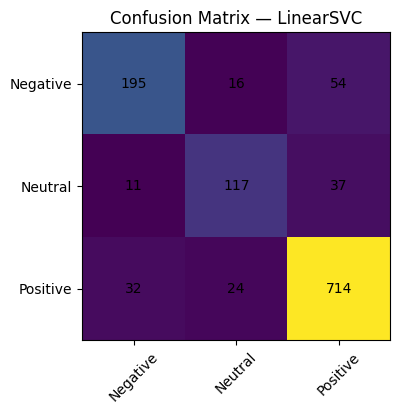

In [ ]:
# Cell 10 — Confusion matrix
best_model_name = max(results, key=lambda k: accuracy_score(y_test, results[k].predict(X_test)))
best_model = results[best_model_name]

cm = confusion_matrix(y_test, best_model.predict(X_test))

plt.figure(figsize=(5,4))
plt.imshow(cm)
plt.title("Confusion Matrix — " + best_model_name)
plt.xticks(range(len(le.classes_)), le.classes_, rotation=45)
plt.yticks(range(len(le.classes_)), le.classes_)

for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")

plt.show()


In [ ]:
# Cell 11 — sample predictions on random reviews
sample = df_sample.sample(8, random_state=5).reset_index(drop=True)
sample_tfidf = tfidf.transform(sample['clean_review'])
sample_preds = best_model.predict(sample_tfidf)

sample['predicted'] = le.inverse_transform(sample_preds)
sample[['review', 'clean_review', 'sentiment', 'predicted']]


,review,clean_review,sentiment,predicted
0,This would got 5 stars month ago. But coupon t...,would got stars month ago coupon time could ti...,Negative,Negative
1,It ok mo probs,ok mo probs,Positive,Positive
2,Nice booking I love,nice booking love,Positive,Positive
3,Greedy execs pushed game stupidity. You can't ...,greedy execs pushed game stupidity win without...,Positive,Positive
4,Easy nice,easy nice,Positive,Positive
5,The stats & layups helped improve,stats layups helped improve,Neutral,Neutral
6,It's good game terribly optimized. It eats bat...,good game terribly optimized eats battery ridi...,Negative,Negative
7,I never recommend coze provide many tools work...,never recommend coze provide many tools work c...,Positive,Positive
